In [1]:
%matplotlib inline


# STARmap processing example

This notebook demonstrates the processing of STARmap data using starfish. The
data we present here is a subset of the data used in this
[publication](https://doi.org/10.1126/science.aat5691) and was generously provided to us by the authors.

In [2]:
from pprint import pprint 

import matplotlib
import matplotlib.pyplot as plt
import numpy as np

import starfish
import starfish.data
from starfish.types import Axes
from starfish.util.plot import (
    diagnose_registration, imshow_plane, intensity_histogram
)

matplotlib.rcParams["figure.dpi"] = 150

## Visualize raw data

In this starmap experiment, starfish exposes a test dataset containing a
single field of view. This dataset contains 672 images spanning 6 rounds
`(r)`, 4 channels `(ch)`, and 28 z-planes `(z)`. Each image
is `1024x1024 (y, x)`

To examine this data, the vignette displays the max projection of channels and
rounds. Ideally, these should form fairly coherent spots, indicating that the
data are well registered. By contrast, if there are patterns whereby pairs of
spots are consistently present at small shifts, that can indicate systematic
registration offsets which should be corrected prior to analysis.

In [14]:
experiment = starfish.data.STARmap(use_test_data=True)
stack_iterator = experiment['fov_000'].get_images('primary', rounds={0, 1, 2})
stack = next(stack_iterator)

100%|██████████| 28/28 [00:00<00:00, 239.80it/s]


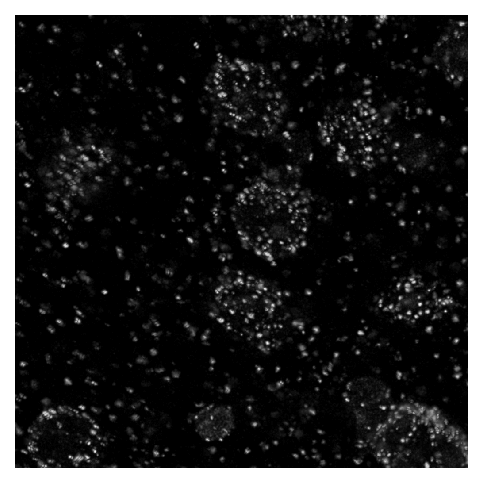

In [15]:
ch_r_projection = stack.max_proj(Axes.CH, Axes.ROUND)

f = plt.figure(dpi=150)
imshow_plane(ch_r_projection, sel={Axes.ZPLANE: 15})

Visualize the codebook
----------------------
The STARmap codebook maps pixel intensities across the rounds and channels to
the corresponding barcodes and genes that those pixels code for. For this
dataset, the codebook specifies 160 gene targets.

In [ ]:
print(experiment.codebook)

## Registration

Starfish exposes some simple tooling to identify registration shifts.
`starfish.util.plot.diagnose_registration` takes an ImageStack and a
set of selectors, each of which maps `Axes` objects
to indices that specify a particular 2d image.

Below the vignette projects the channels and z-planes and examines the
registration of those max projections across channels 0 and 1. To make the
difference more obvious, we zoom in by selecting a subset of the image, and
display the data before and after registration.

It looks like there is a small shift approximately the size of a spot
in the `x = -y` direction for at least the plotted rounds

The starfish package can attempt a translation registration to fix this
registration error.

In [16]:
projection = stack.max_proj(Axes.CH, Axes.ZPLANE)
reference_image = projection.sel({Axes.ROUND: 0})

ltt = starfish.image.LearnTransform.Translation(
    reference_stack=reference_image,
    axes=Axes.ROUND,
    upsampling=1000,
)
transforms = ltt.run(projection)

100%|██████████| 3/3 [00:00<00:00, 272.80it/s]


How big are the identified translations? 

In [10]:
pprint([t[2].translation for t in transforms.transforms])

[array([0., 0.])]


Apply the translations

In [17]:
warp = starfish.image.ApplyTransform.Warp()
stack = warp.run(
    stack=stack,
    transforms_list=transforms,
)

Show the effect of registration.

In [19]:
post_projection = stack.max_proj(Axes.CH, Axes.ZPLANE)

100%|██████████| 3/3 [00:00<00:00, 197.34it/s]


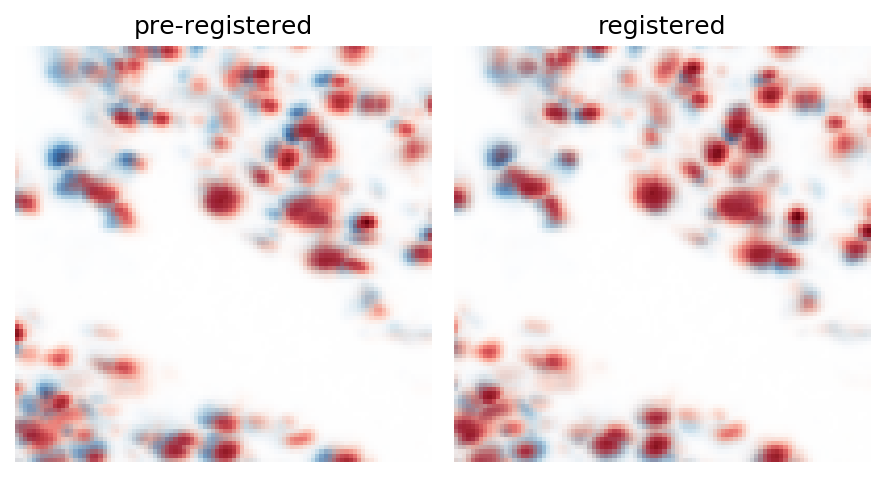

In [20]:
f, (ax1, ax2) = plt.subplots(ncols=2)
sel_0 = {Axes.ROUND: 0, Axes.X: (500, 600), Axes.Y: (500, 600)}
sel_1 = {Axes.ROUND: 1, Axes.X: (500, 600), Axes.Y: (500, 600)}
diagnose_registration(
    projection, sel_0, sel_1, ax=ax1, title='pre-registered'
)
diagnose_registration(
    post_projection, sel_0, sel_1, ax=ax2, title='registered'
)
f.tight_layout()

The plot shows that the slight offset has been corrected.

Equalize channel intensities
----------------------------
The second stage of the STARmap pipeline is to align the intensity
distributions across channels and rounds. Here we calculate a reference
distribution by sorting each image's intensities in increasing order and
averaging the ordered intensities across rounds and channels. All `(z, y, x)`
volumes from each round and channel are quantile normalized against this
reference.

Note that this type of histogram matching has an implied assumption that each
channel has relatively similar numbers of spots. In the case of this data
this assumption is reasonably accurate, but for other datasets it can be
problematic to apply filters that match this stringently.

In [21]:
mh = starfish.image.Filter.MatchHistograms({Axes.CH, Axes.ROUND})
scaled = mh.run(stack, in_place=False, verbose=True, n_processes=8)

Calculating reference distribution...


12it [01:20,  7.50s/it]


In [ ]:
def plot_scaling_result(
    template: starfish.ImageStack, scaled: starfish.ImageStack
):
    f, (before, after) = plt.subplots(ncols=4, nrows=2)
    for channel, ax in enumerate(before):
        title = f'Before scaling\nChannel {channel}'
        intensity_histogram(
            template, sel={Axes.CH: channel, Axes.ROUND: 0}, ax=ax, title=title,
            log=True, bins=50,
        )
        ax.set_xlim((0, 1))
    for channel, ax in enumerate(after):
        title = f'After scaling\nChannel {channel}'
        intensity_histogram(
            scaled, sel={Axes.CH: channel, Axes.ROUND: 0}, ax=ax, title=title,
            log=True, bins=50,
        )
        ax.set_xlim((0, 1))
    f.tight_layout()
    return f

f = plot_scaling_result(stack, scaled)

Find spots
----------
Finally, a local blob detector that finds spots in each (z, y, x) volume
separately is applied. The user selects an "anchor round" and spots found in
all channels of that round are used to seed a local search across other rounds
and channels. The closest spot is selected, and any spots outside the search
radius (here 10 pixels) is discarded.

The Spot finder returns an IntensityTable containing all spots from round
zero. Note that many of the spots do _not_ identify spots in other rounds and
channels and will therefore fail decoding. Because of the stringency built
into the STARmap codebook, it is OK to be relatively permissive with the spot
finding parameters for this assay.

In [22]:
lsbd = starfish.spots.DetectSpots.LocalSearchBlobDetector(
    min_sigma=1,
    max_sigma=8,
    num_sigma=10,
    threshold=np.percentile(np.ravel(stack.xarray.values), 95),
    exclude_border=2,
    anchor_round=0,
    search_radius=10,
)
intensities = lsbd.run(scaled, n_processes=8)

In [28]:
print(intensities.shape)
codebook = indexing_utils.index_keep_dimensions(experiment.codebook, {Axes.ROUND: slice(0, 2)})
print(codebook.shape)

(4794, 4, 3)
(160, 4, 3)


Decode spots
------------
Next, spots are decoded. There is really no good way to display 3-d spot
detection in 2-d planes, so we encourage you to grab this notebook and
uncomment the below lines.

In [30]:
from starfish.core.imagestack import indexing_utils

codebook = indexing_utils.index_keep_dimensions(experiment.codebook, {Axes.ROUND: slice(0, 2)})
print(intensities.shape)
print(codebook.shape)

decoded = experiment.codebook.decode_per_round_max(intensities.fillna(0))
decode_mask = decoded['target'] != 'nan'

# %gui qt
# viewer = starfish.display(
#     stack, decoded[decode_mask], radius_multiplier=2, mask_intensities=0.1
# )

(4794, 4, 3)
(160, 4, 3)


ValueError: Codebook and Intensities must have same number of channels and rounds